In [ ]:
### Code from https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb

In [1]:
# !git clone https://github.com/ContinualAI/colab.git continualai/colab

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# !pwd

In [5]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/miniconda/envs/det2/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


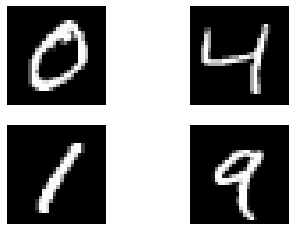

In [8]:
%matplotlib inline

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/rapid_data/dsfashionshare/miniconda/envs/det2/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
torch.manual_seed(1)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [13]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
        end = start + 256
        with torch.no_grad():
            x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
            x, y = x.to(device), y.to(device)
            output = model(x)
            test_loss += F.cross_entropy(output, y).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max logit
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [15]:
for epoch in range(1, 3):
    train(model, device, x_train, t_train, optimizer, epoch)
    test(model, device, x_test, t_test)

/rapid_data/dsfashionshare/miniconda/envs/det2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 	Loss: 0.650753
Test set: Average loss: 0.0013, Accuracy: 9020/10000 (90%)

Train Epoch: 2 	Loss: 0.395812
Test set: Average loss: 0.0007, Accuracy: 9428/10000 (94%)



In [16]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [17]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


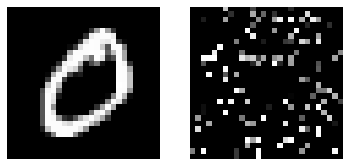

In [18]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [19]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9428/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1082/10000 (11%)



In [20]:
for epoch in range(1, 3):
    train(model, device, x_train2, t_train, optimizer, epoch)
    test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.555232
Test set: Average loss: 0.0032, Accuracy: 7408/10000 (74%)

Train Epoch: 2 	Loss: 1.229233
Test set: Average loss: 0.0021, Accuracy: 8295/10000 (83%)



In [21]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test)

Testing on the first task:
Test set: Average loss: 0.0210, Accuracy: 2606/10000 (26%)

Testing on the second task:
Test set: Average loss: 0.0021, Accuracy: 8295/10000 (83%)



82.95

In [22]:
### 3-tasks Permuted MNIST for continual learning evaluation

# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [23]:
### Elastic Weights Consolidation (EWC)

# Computation of the importance of each weight (fisher information) and a squared regularization loss,
# penalizing changes in the most important wheights for the previous tasks.

# Does not use any of the previous tasks data!

fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)
print(optimizer)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [38]:
# ewc_accs = []
# print(tasks[0][0][0].shape)

# id=0
# task=tasks[id]

# avg_acc = 0
# print("Training on task: ", id)

# (x_train, t_train), _ = task

# print(x_train.shape)

# epoch=0

# model.train()

# start=0
# end = start + 256
# x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
# x, y = x.to(device), y.to(device) ## is a mini-batch

# print(x.size(),y.size())

# optimizer.zero_grad()

# output = model(x)
# loss = F.cross_entropy(output, y)

# print(loss)

# task=0

# for name, param in model.named_parameters():
#     fisher = fisher_dict[task][name]
#     optpar = optpar_dict[task][name]
#     loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

In [39]:
def on_task_update(task_id, x_mem, t_mem):

    model.train()
    optimizer.zero_grad()

    # accumulating gradients
    for start in range(0, len(t_mem)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()

    fisher_dict[task_id] = {}
    optpar_dict[task_id] = {}

    # gradients accumulated can be used to calculate fisher
    for name, param in model.named_parameters():
        optpar_dict[task_id][name] = param.data.clone()
        fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

In [40]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)

        ### magic here! :-)
        for task in range(task_id):
            for name, param in model.named_parameters():
                fisher = fisher_dict[task][name]
                optpar = optpar_dict[task][name]
                loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
        loss.backward()
        optimizer.step()
        #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [41]:
ewc_accs = []
for id, task in enumerate(tasks):
    avg_acc = 0
    print("Training on task: ", id)

    (x_train, t_train), _ = task

    for epoch in range(1, 3):
        train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
    on_task_update(id, x_train, t_train)
    
    for id_test, task in enumerate(tasks):
        print("Testing on task: ", id_test)
        _, (x_test, t_test) = task
        acc = test(model, device, x_test, t_test)
        avg_acc = avg_acc + acc
   
    print("Avg acc: ", avg_acc / 3)
    ewc_accs.append(avg_acc / 3)

Training on task:  0
Train Epoch: 1 	Loss: 0.734618
Train Epoch: 2 	Loss: 0.695170
Testing on task:  0
Test set: Average loss: 0.0008, Accuracy: 9396/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0116, Accuracy: 591/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0102, Accuracy: 1204/10000 (12%)

Avg acc:  37.303333333333335
Training on task:  1
Train Epoch: 1 	Loss: 1.976301
Train Epoch: 2 	Loss: 1.596894
Testing on task:  0
Test set: Average loss: 0.0086, Accuracy: 4899/10000 (49%)

Testing on task:  1
Test set: Average loss: 0.0031, Accuracy: 7798/10000 (78%)

Testing on task:  2
Test set: Average loss: 0.0109, Accuracy: 1386/10000 (14%)

Avg acc:  46.94333333333333
Training on task:  2
Train Epoch: 1 	Loss: 2.066649
Train Epoch: 2 	Loss: 1.897922
Testing on task:  0
Test set: Average loss: 0.0064, Accuracy: 5657/10000 (57%)

Testing on task:  1
Test set: Average loss: 0.0078, Accuracy: 2832/10000 (28%)

Testing on task:  2
Test set: Average loss: 0.0040, Accu